In [33]:
import iucn_data
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as pgd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
from prophet import Prophet
from prophet.plot import plot_forecast_component, plot_yearly

In [34]:
country_co2_raw = pd.read_csv("../data/country/CO2/API_EN.ATM.CO2E.KT_DS2_en_csv_v2_3470002.csv", quotechar = '"', skiprows=4)
country_fst_raw = pd.read_csv("../data/country/Forest/API_AG.LND.FRST.ZS_DS2_en_csv_v2_3469441.csv", quotechar = '"', skiprows=4)
country_pop_raw = pd.read_csv("../data/country/Population/API_SP.POP.GROW_DS2_en_csv_v2_3469469.csv", quotechar = '"', skiprows=4)
country_me_raw = pd.read_csv("../data/country/methan/API_EN.ATM.METH.KT.CE_DS2_en_csv_v2_3471999.csv", quotechar = '"', skiprows=4)
country_re_raw = pd.read_csv("../data/country/RE/API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_3471475.csv", quotechar = '"', skiprows=4)


historical_df = iucn_data.get_merged_historical_info()
threats_df = iucn_data.get_merged_threats_info()
habitat_df = iucn_data.get_merged_habitat_info()
animalia_df = iucn_data.get_animalia_df()
country_df = iucn_data.get_merged_country_info()

In [35]:
def trs_data(df, value_name):
    temp = (df
                        .rename(columns={"Country Code": "Code"})
                        .drop(['Indicator Code', 'Indicator Name', 'Country Name', '2020', '2019', 'Unnamed: 65'], axis=1)
                        .melt(id_vars=['Code'],var_name='year', value_name=f'{value_name}'))
    return temp


df1 = trs_data(country_co2_raw, 'co2')
df2 = trs_data(country_fst_raw, 'forest')
df3 = trs_data(country_pop_raw, 'population')
df4 = trs_data(country_me_raw, 'methan')
df5 = trs_data(country_re_raw, 'renewable_energy')

df = animalia_df.join(country_df, how='left')
historical_df = historical_df.drop(['category', 'code'], axis=1)
dfs = df.join(historical_df, how='left')
dfs_min = dfs[['assessment_date', 'category', 'country', 'code_3', 'assess_year']]
dfs_min= dfs_min.rename(columns={"assess_year": "year", "code_3": "Code"})

merge = pd.merge(df1, df2, on=['Code', 'year'])
merge = pd.merge(merge, df3, on=['Code', 'year'])
merge = pd.merge(merge, df4, on=['Code', 'year'])
merge_data = pd.merge(merge, df5, on=['Code', 'year'])
merge_data["year"] = merge_data["year"].astype(str).astype(int)

final = dfs_min.merge(merge_data, how='right', on=['Code', 'year'])

In [36]:
hist_df = iucn_data.get_merged_historical_info().reset_index()
cat = ["Endangered", "Critically Endangered", "Vulnerable"]
label_mapping = {"Critically Endangered":"CR", "Endangered":"EN", "Vulnerable":"VU"}
cat_cols = ["indianred", "lightblue", "darkred"]
df = hist_df.query(f'category in {cat}')

df['category'] = df['category'].map(label_mapping)

df = df.groupby(['taxonid_iucn', 'category'])['year'].min().reset_index()
df = df.groupby(['year', 'category']).count()
df.columns = ['counts']

df['no_csum'] = df.groupby(['category'])['counts'].cumsum()



df_splt = df.reset_index()

predict_df = df_splt.merge(final, how='right', on=['category', 'year'])
corr = df_splt.merge(final, how='right', on=['category', 'year'])
predict_df = predict_df.dropna(subset = ['co2', 'forest', 'population', 'methan', 'renewable_energy', 'category']).reset_index(drop=True)
predict_df['assessment_date'] =  pd.to_datetime(predict_df['assessment_date'])
predict_df = predict_df.rename(columns={"assessment_date": "ds", "no_csum": "y"})

<ipython-input-36-f7e4f9795e9d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = df['category'].map(label_mapping)


                      year    counts         y       co2    forest  \
year              1.000000 -0.243022  0.907064 -0.032644 -0.028126   
counts           -0.243022  1.000000 -0.055426  0.016407  0.031845   
y                 0.907064 -0.055426  1.000000 -0.015946 -0.021967   
co2              -0.032644  0.016407 -0.015946  1.000000 -0.070298   
forest           -0.028126  0.031845 -0.021967 -0.070298  1.000000   
population       -0.078897  0.001777 -0.072916 -0.174400 -0.104481   
methan           -0.052380  0.030216 -0.031644  0.870095 -0.041505   
renewable_energy -0.048258  0.015936 -0.049470 -0.249334  0.135298   

                  population    methan  renewable_energy  
year               -0.078897 -0.052380         -0.048258  
counts              0.001777  0.030216          0.015936  
y                  -0.072916 -0.031644         -0.049470  
co2                -0.174400  0.870095         -0.249334  
forest             -0.104481 -0.041505          0.135298  
population     

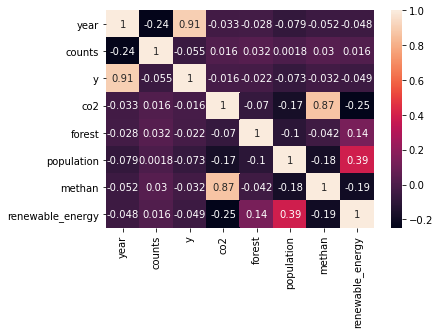

In [37]:
corrMatrix = predict_df.corr()
print (corrMatrix)
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [38]:
## split train test
##

f_train = predict_df.loc[predict_df["ds"]<"2010-01-01"]
f_test = predict_df.loc[predict_df["ds"]>"2010-01-01"]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


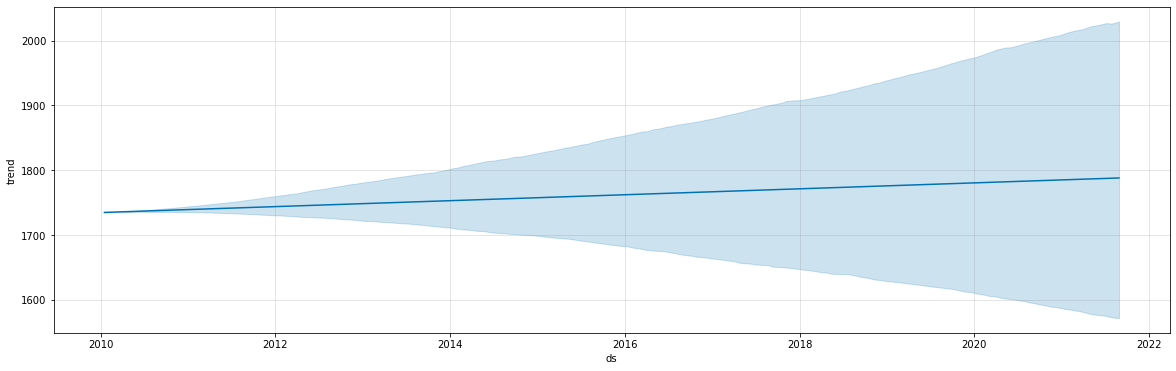

In [39]:
## Prediction Without charectiristics
##

m = Prophet()

m.fit((f_train))


forcast = m.predict(f_test.drop(columns="y"))
plot_forecast_component(m, forcast, name='trend', uncertainty=True, figsize=(20, 6))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


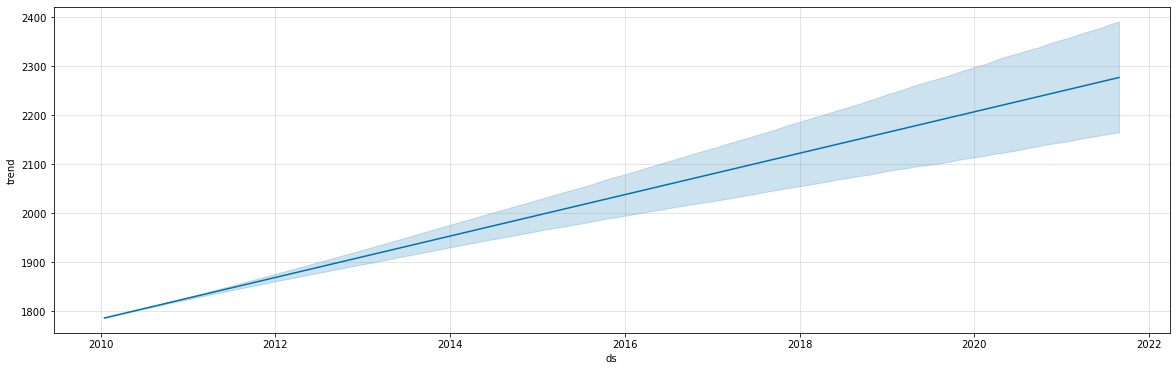

In [40]:
## prediction with Charectiristics

m = Prophet()

m.add_regressor('co2')
m.add_regressor('forest')
m.add_regressor('population')
m.add_regressor('methan')
m.add_regressor('renewable_energy')

m.fit((f_train))


forcast = m.predict(f_test.drop(columns="y"))
plot_forecast_component(m, forcast, name='trend', uncertainty=True, figsize=(20, 6))